<a href="https://colab.research.google.com/github/yangtommy6/Deep-Learning-Projects/blob/main/Bear_Reconitioni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Is it a bear? Creating a model from your own data

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '90086a15a7704edeb954308d3595f8a1')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('contentUrl')
len(ims)

150

In [6]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [7]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

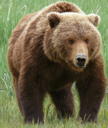

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

In [9]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [10]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [11]:
fns = get_image_files(path)
fns

(#429) [Path('bears/grizzly/0e4e45aa-2c21-4e66-9355-23131e05c22d.jpg'),Path('bears/grizzly/d451bddd-2654-46d2-96ea-ffd47c6a4950.jpg'),Path('bears/grizzly/93a769e1-ceae-4bff-98c6-6bab29cd218a.jpg'),Path('bears/grizzly/5fc5d3ac-73f4-4059-b97c-a0e77d1f8c9f.jpg'),Path('bears/grizzly/9aeb7649-ae1e-4c7c-afee-8a40e6cce381.jpg'),Path('bears/grizzly/510e01c6-5c27-4836-9840-58b6787007ca.jpg'),Path('bears/grizzly/4062f457-68ef-4d62-8eda-407f1de9e618.jpg'),Path('bears/grizzly/4d8a4b38-45f7-49e1-ba0f-0f66049b6295.JPG'),Path('bears/grizzly/c62e099c-e758-41db-b018-1d6806a4cf8e.jpg'),Path('bears/grizzly/605eadff-0706-4b6d-b2bc-b43fa3a8961b.jpg')...]

In [12]:
failed = verify_images(fns)
failed

(#0) []

In [13]:
failed.map(Path.unlink);

In [14]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = bears.dataloaders(path)


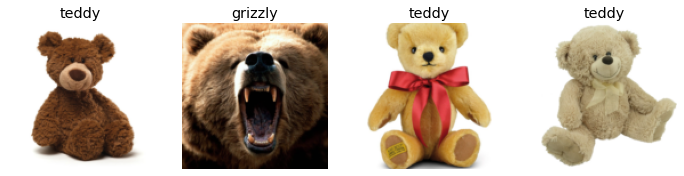

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

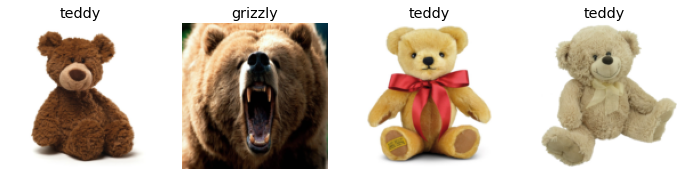

In [17]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

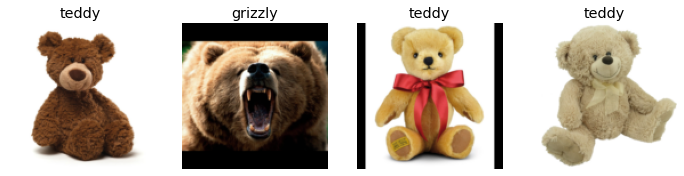

In [18]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

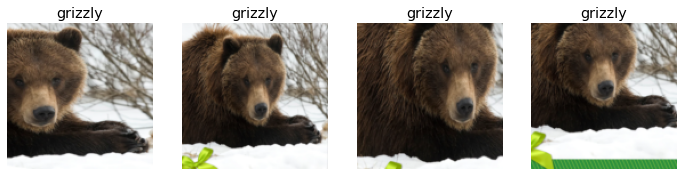

In [19]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

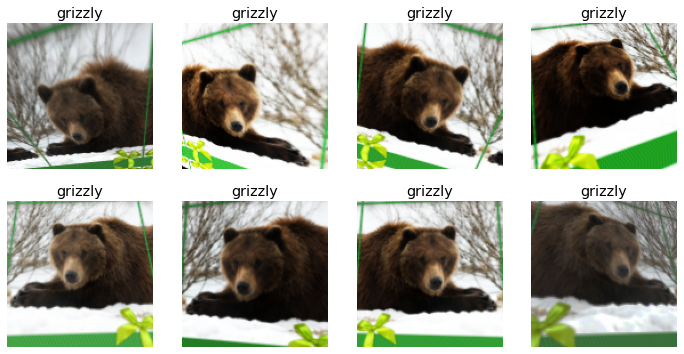

In [20]:
#Data Augmentation
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [21]:
#Training the model
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.478527,0.093108,0.023529,01:25


epoch,train_loss,valid_loss,error_rate,time
0,0.171241,0.059634,0.011765,01:55
1,0.124456,0.058561,0.011765,01:47
2,0.097030,0.073294,0.011765,01:49
3,0.075711,0.072943,0.011765,01:46


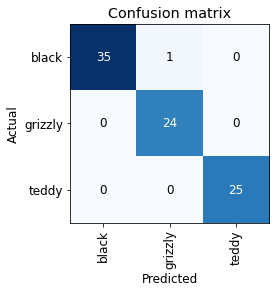

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

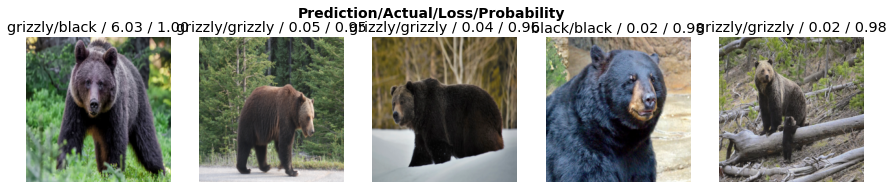

In [24]:
interp.plot_top_losses(5, nrows=1)

In [25]:
#Manually cleanup the training samples that are wrong.
cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
#Use this to submit the configuration
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)


In [27]:
learn.export()

In [28]:
path = Path()
path.ls(file_exts = '.pkl')

(#1) [Path('export.pkl')]

In [29]:
learn_inf = load_learner(path/'export.pkl')

In [30]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', TensorBase(1), TensorBase([1.4601e-06, 1.0000e+00, 7.4200e-08]))

In [31]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [32]:
btn_upload = widgets.FileUpload()
btn_upload


FileUpload(value={}, description='Upload')

In [33]:
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [34]:
img = PILImage.create(btn_upload.data[-1])

In [35]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [37]:
pred,pred_idx,probs = learn_inf.predict(img)

In [38]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred


Label(value='Prediction: grizzly; Probability: 1.0000')

In [39]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [42]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [43]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [44]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [45]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila 0.3.6 OK
